This notebooks works like the monte_carlo notebook, except with only one price and one market situation.
The time between adjustmensts of prices gets split into B parts and for each purchase the time slot o fit is tracked. At the end, it creates a graph. The time horizon is 1.

In [1]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
numberPlayers = 5
timeHorizon = 1
numberMarketReactionEvents = round(1.1*timeHorizon)
meanTimeBetweenCustomerArrival = 2
numberOfCustomerEvents = round(1.1*timeHorizon/meanTimeBetweenCustomerArrival)   # values used for paper: (np.arange(0,15.1,0.1))
watchedCompany = 0
numberSimulations = 10000  
m = 2
numberCustomerEvents = 4
reactionTimeCompany = timeHorizon
intensity_price = 7
bb = 20
strategies = ["S1","S2","S3"]
random.seed(12530586)

In [3]:
pricesCompanies = np.array([round(random.uniform(6,16),2) for _ in range(numberPlayers)])
qualityCompanies = np.array([round(random.uniform(0.5,5.5)) for _ in range(numberPlayers)])
ratingCompanies = np.array([round(random.uniform(90,100),1) for _ in range(numberPlayers)])

In [4]:
def price_if_smaller_else(price, price_smaller, else_min, prices_comp, c):
    return(price if min(prices_comp[comp] for comp in range(numberPlayers) if comp!=c)< price_smaller else round(min([max(else_min, prices_comp[company]-0.5) for company in range(numberPlayers) if company != c]),2))

s1 = {
        '0' : lambda pricesCompanies, c: round(random.uniform(0,15),2),
        '1' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '2' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '3' : lambda pricesCompanies, c: round(random.uniform(5,15),2),
        '4' : lambda pricesCompanies, c: round(random.uniform(5,15),2)
    }

s2 = {
        '0' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '1' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '2' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '3' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '4' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c)
    }

s3 = {
        '0' : lambda pricesCompanies, c: price_if_smaller_else(10,5,4.9,pricesCompanies,c),
        '1' : lambda pricesCompanies, c: price_if_smaller_else(9,4,3.9,pricesCompanies,c),
        '2' : lambda pricesCompanies, c: price_if_smaller_else(12,6,5.9,pricesCompanies,c),
        '3' : lambda pricesCompanies, c: 11,
        '4' : lambda pricesCompanies, c: 13
    }

In [5]:
def calculateTimeOfAdjustmentsCompany(company, i, timeBetweenMarketEventsCompany, first_reaction):
    if i==0:
        if company != watchedCompany:
            return first_reaction[company][i]
        else:
            return(reactionTimeCompany)
    else:
        return(calculateTimeOfAdjustmentsCompany(company, i-1, timeBetweenMarketEventsCompany, first_reaction)+ timeBetweenMarketEventsCompany[company][i-1])
    
def calculateTimeOfCustomerArrival(customer, timeBetweenMarketEventsCustomer):
    if customer==0:
        return timeBetweenMarketEventsCustomer[customer]
    else:
        return(calculateTimeOfCustomerArrival(customer-1, timeBetweenMarketEventsCustomer) + timeBetweenMarketEventsCustomer[customer])

def calculatePrices(pricesCompaniesAdjustments, adjustingFirm, strategy):
    pricesCompaniesAdjustments = np.array(pricesCompaniesAdjustments)
    for i in range(1,len(pricesCompaniesAdjustments)-1):        
        pricesCompaniesAdjustments[i:,adjustingFirm[i]] = strategy[str(adjustingFirm[i])](pricesCompaniesAdjustments[i-1],adjustingFirm[i])
    pricesCompaniesAdjustments[len(pricesCompaniesAdjustments)-1] = pricesCompaniesAdjustments[len(pricesCompaniesAdjustments)-2]
    return pricesCompaniesAdjustments

In [ ]:
timeBetweenMarketEventsCompany = np.array([[[random.uniform(0.8,1.2) for i in range(m)] for company in range(numberPlayers)] for _ in range(numberSimulations)])
first_reaction = np.array([[[random.uniform(0,1) for i in range(m)] for company in range(numberPlayers)] for _ in range(numberSimulations)])
timeOfAdjustmentsCompany = np.array([[[calculateTimeOfAdjustmentsCompany(company ,i, timeBetweenMarketEventsCompany[simulationNumber], first_reaction[simulationNumber]) for i in range(m)] for company in range(numberPlayers)] for simulationNumber in range(numberSimulations)])
priceAdjustmentsBeforeHorizon = np.array([set([timeOfAdjustmentsCompany[simulationNumber].flatten()[i] for i in range(len(timeOfAdjustmentsCompany[simulationNumber].flatten())) if timeOfAdjustmentsCompany[simulationNumber].flatten()[i] < timeHorizon]) for simulationNumber in range(numberSimulations)])

priceAdjustmentsBeforeHorizon = np.array([sorted(priceAdjustmentsBeforeHorizon[simulationNumber])+[timeHorizon] for simulationNumber in range(numberSimulations)])

numberPriceAdjustmentsBeforeHorizon = np.array([len(priceAdjustmentsBeforeHorizon[simulationNumber]) for simulationNumber in range(numberSimulations)])

timeMarketEvents = np.array([[0 if i==0 else priceAdjustmentsBeforeHorizon[simulationNumber][i-1] for i in range(numberPriceAdjustmentsBeforeHorizon[simulationNumber]+1)]for simulationNumber in range(numberSimulations)])

adjustingFirm = np.array([[min(np.where(timeOfAdjustmentsCompany[simulationNumber]==priceAdjustmentsBeforeHorizon[simulationNumber][i] )[0]) if priceAdjustmentsBeforeHorizon[simulationNumber][i]!= timeHorizon and i!=0 else -1 for i in range(numberPriceAdjustmentsBeforeHorizon[simulationNumber])] for simulationNumber in range(numberSimulations)])
timeBetweenCustomerEvents = np.array([[meanTimeBetweenCustomerArrival*np.random.exponential() for _ in range(numberCustomerEvents)]for simulationNumber in range(numberSimulations)])
timeCustomerEvents = np.array([[calculateTimeOfCustomerArrival(customer, timeBetweenCustomerEvents[simulationNumber]) for customer in range(numberCustomerEvents)] for simulationNumber in range(numberSimulations)])

randomCustomerScoringQuality = np.array([[random.uniform(0,1) for _ in range(numberCustomerEvents)] for simulationNumber in range(numberSimulations)])
randomCustomerScoringRating = np.array([[random.uniform(0,0.5) for _ in range(numberCustomerEvents)] for simulationNumber in range(numberSimulations)])

customerScoringQualityRating = np.array([[[(randomCustomerScoringQuality[s][c]*2 +
    randomCustomerScoringRating[s][c]*(100-98))for k in range(numberPlayers)] for c in range(numberCustomerEvents)] for s in range(numberSimulations)])

pricesCompanies = np.array([intensity_price+20.5+2*(k-2) if k!=watchedCompany else intensity_price  for k in range(numberPlayers)])
pricesCompaniesAdjustments = np.array([[[pricesCompanies[k]  for k in range(numberPlayers)]for _ in range(numberPriceAdjustmentsBeforeHorizon[s])] for s in range(numberSimulations)])
pricesCompaniesAdjustments = np.array([[np.array(calculatePrices(pricesCompaniesAdjustments[s], adjustingFirm[s], globals()["s{}".format(strat+1)])) for s in range(numberSimulations)]for strat in range(len(strategies))])

gen = np.array([[list([x for x in range(numberCustomerEvents) if timeMarketEvents[s][i]< timeCustomerEvents[s][x]< timeMarketEvents[s][i+1]]) for i in range(numberPriceAdjustmentsBeforeHorizon[s])] for s in range(numberSimulations)] )

randomCustomerScoring = np.array([[[[[(pricesCompaniesAdjustments[strat,s][i,k] + customerScoringQualityRating[s,c,k]) for k in range(numberPlayers)]for c in gen[s][i]]for i in range(numberPriceAdjustmentsBeforeHorizon[s])] for s in range(numberSimulations)]for strat in range(len(strategies))])
randomCustomerDecision = np.array([[[[np.argmin(randomCustomerScoring[strat,s][i][c]) if min(randomCustomerScoring[strat,s][i][c])< random.uniform(5,15) else -1 for c in range(len(gen[s][i]))]for i in range(numberPriceAdjustmentsBeforeHorizon[s])] for s in range(numberSimulations)]for strat in range(len(strategies))])

b = np.array([[[int(round((timeCustomerEvents[s][c]+1/bb/2)*bb))for c in range(len(gen[s][i]))]for i in range(numberPriceAdjustmentsBeforeHorizon[s])] for s in range(numberSimulations)])

At = np.array([[[sum([sum([sum([1 if b[s][i][c]==t and randomCustomerDecision[strat,s][i][c]==k  else 0 for c in range(len(gen[s][i]))])for i in range(numberPriceAdjustmentsBeforeHorizon[s])])for s in range(numberSimulations)])for k in range(numberPlayers)]for t in range(reactionTimeCompany*bb+1)]for strat in range(len(strategies))])
                        
x = [t/bb for t in range(1,reactionTimeCompany*bb+1)]

plt.plot(x, [At[0,t][watchedCompany]/numberSimulations*bb for t in range(1,len(x)+1)], 'b-', label='Setup 1')
plt.plot(x, [At[1,t][watchedCompany]/numberSimulations*bb for t in range(1,len(x)+1)], 'r-', label='Setup 2')
plt.plot(x, [At[2,t][watchedCompany]/numberSimulations*bb for t in range(1,len(x)+1)], 'g-', label='Setup 3')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('E(λ$_t$)')

Simulated expected sales intensities of firm 1 over one period of time time for different competitive setups (i)-(iii), starting in market situation s0 , cf.

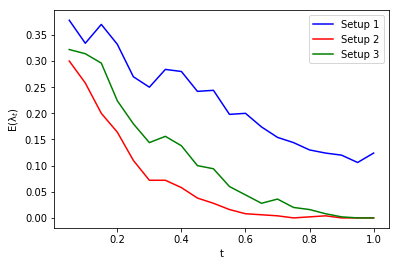

In [7]:
plt.show()